# Load Dataset

In [ ]:
from datasets import load_dataset, DatasetDict
ds = load_dataset("imagefolder", data_dir = "Datasets")
print(ds)
ds = ds["train"].train_test_split(test_size = 0.15, seed=42)
ds = DatasetDict({
        "train": ds["train"],
        "test": ds["test"]
    })
ds

Resolving data files:   0%|          | 0/16119 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 16119
    })
})


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 13701
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2418
    })
})

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x168 at 0x77F9F4FBA1D0>, 'label': 1}


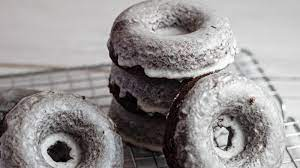

In [ ]:
ex = ds['train'][400]
print(ex)
image = ex['image']
image

In [ ]:
labels = ds["train"].features['label']
labels

ClassLabel(names=['Crispy Chicken', 'Donut', 'Fries', 'Hot Dog', 'Taco', 'apple_pie', 'burger', 'chai', 'cheesecake', 'chicken_curry', 'chole_bhature', 'dal_makhani', 'dhokla', 'fried_rice', 'jalebi', 'kaathi_rolls', 'kulfi', 'omelette', 'pakode', 'pav_bhaji', 'pizza', 'sushi'], id=None)

In [ ]:
labels.int2str(ex['label'])

'Donut'

# Preprocessing

In [ ]:
from transformers import ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)
print(processor)

2025-03-11 16:39:47.091569: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-11 16:39:47.099703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741682387.108203   24789 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741682387.111540   24789 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-11 16:39:47.125082: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



In [ ]:
def transform(example_batch):
    images = [x.convert("RGB") for x in example_batch["image"]]  # Convert to RGB (3 channels)

    # Process images
    inputs = processor(images, return_tensors="pt")

    inputs['label'] = example_batch['label']
    return inputs

prepared_ds = ds.with_transform(transform)

# Training and Evaluation

In [ ]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [ ]:
import numpy as np
from evaluate import load

metric = load("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


In [ ]:
from transformers import ViTForImageClassification

labels = ds['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./finetune1",
  per_device_train_batch_size=16,
  eval_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["test"],
    processing_class=processor,
)

# Train

In [ ]:
# train_results = trainer.train()
# trainer.save_model()
# trainer.log_metrics("train", train_results.metrics)
# trainer.save_metrics("train", train_results.metrics)
# trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,0.960600,0.964605,0.823821
200,0.598500,0.677571,0.844913
300,0.417600,0.501341,0.879239
400,0.552600,0.545774,0.848222
500,0.351200,0.455915,0.881720
600,0.421200,0.444211,0.882961
700,0.522100,0.443649,0.870141
800,0.346800,0.352789,0.898263
900,0.164700,0.393101,0.889578
1000,0.091100,0.393192,0.898263


/home/huinker/Coding/python/aiml_env/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/huinker/Coding/python/aiml_env/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/huinker/Coding/python/aiml_env/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/huinker/Coding/python/aiml_env/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/huinker/Coding/python/aiml_env/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/huinker/Coding/python/aiml_env/li

***** train metrics *****
  epoch                    =          4.0
  total_flos               = 3955915818GF
  train_loss               =       0.2112
  train_runtime            =   0:26:56.49
  train_samples_per_second =       33.903
  train_steps_per_second   =        2.121


In [ ]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)


/home/huinker/Coding/python/aiml_env/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9376
  eval_loss               =     0.2373
  eval_runtime            = 0:00:24.12
  eval_samples_per_second =     100.24
  eval_steps_per_second   =     12.561


In [ ]:
from transformers import ViTForImageClassification, ViTImageProcessor
import torch
from PIL import Image

# Load trained model (change path if needed)
model_path = "./finetune1"  # Use your actual model save directory
model = ViTForImageClassification.from_pretrained(model_path)
processor = ViTImageProcessor.from_pretrained(model_path)

# Set model to evaluation mode (important for inference)
model.eval()

# Load an image (replace with your own image path)
image_path = "tomato.jpeg"  # Change to your image file path
image = Image.open(image_path).convert("RGB")  # Ensure it's RGB


In [ ]:
# Preprocess the image using the processor
inputs = processor(images=image, return_tensors="pt")

# Perform inference
with torch.no_grad():  # No gradients needed for testing
    outputs = model(**inputs)
# Extract predictions
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()

# Get class label from model's config
id2label = model.config.id2label  # Mapping class index to label
predicted_label = id2label[predicted_class_idx]

In [ ]:
import torch.nn.functional as F

# Convert logits to probabilities
probs = F.softmax(logits, dim=-1)
confidence = probs[0, predicted_class_idx].item()

if confidence >= 0.70:
    print(f"Predicted class: {predicted_label} with confidence: {confidence:.2f}")
else:
    print("I don't know")


I don't know
